<a href="https://colab.research.google.com/github/MthabisiPatrice/Machine-Learning-/blob/main/Classification_3model_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Multiclass Diabetes Classification Analysis
# A Comprehensive Machine Learning Approach

## Dataset Description and Objectives

*Dataset Overview:**
This analysis focuses on a multiclass diabetes dataset containing 520 patient records with 11 clinical features and a target variable representing three diabetes classes:
- Class 0: No diabetes
- Class 1: Pre-diabetes
- Class 2: Diabetes

**Attributes Summary:**
- **Gender**: Binary (0=Female, 1=Male)
- **AGE**: Patient age in years
- **Urea**: Blood urea nitrogen levels
- **Cr**: Serum creatinine levels
- **HbA1c**: Glycated hemoglobin percentage
- **Chol**: Total cholesterol
- **TG**: Triglycerides
- **HDL**: High-density lipoprotein
- **LDL**: Low-density lipoprotein
- **VLDL**: Very low-density lipoprotein
- **BMI**: Body Mass Index
- **Class**: Target variable (0, 1, 2)

**Objective:**
The primary goal is to develop robust classification models that can accurately predict diabetes status based on clinical markers, providing insights into the most important predictive factors for diabetes progression.


In [33]:
#Loading my necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

In [34]:
#Loading dataset and visualization enhancer

# Setting the style for better visuals.
plt.style.use('default')
sns.set_palette("husl")

# here I am loading my diabetes dataset
data = pd.read_csv('/content/diabetes.csv')
print("Dataset Shape:", data.shape)
print(data.head())

Dataset Shape: (264, 12)
   Gender  AGE  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI  Class
0       0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      0
1       1   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0      0
2       1   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0      0
3       0   45   2.3  24    4.0   2.9  1.0  1.0  1.5   0.4  21.0      0
4       0   50   2.0  50    4.0   3.6  1.3  0.9  2.1   0.6  24.0      0


In [35]:
## Data Exploration and Initial Analysis

# Basic dataset information
print("Dataset Info:")
print(data.info())
print("\nMissing Values:")
print(data.isnull().sum())
print("\nClass Distribution:")
print(data['Class'].value_counts().sort_index())

# Statistical summary of all my features so I can have a better understanding of things.
print("\nStatistical Summary:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Gender  264 non-null    int64  
 1   AGE     264 non-null    int64  
 2   Urea    264 non-null    float64
 3   Cr      264 non-null    int64  
 4   HbA1c   264 non-null    float64
 5   Chol    264 non-null    float64
 6   TG      264 non-null    float64
 7   HDL     264 non-null    float64
 8   LDL     264 non-null    float64
 9   VLDL    264 non-null    float64
 10  BMI     264 non-null    float64
 11  Class   264 non-null    int64  
dtypes: float64(8), int64(4)
memory usage: 24.9 KB
None

Missing Values:
Gender    0
AGE       0
Urea      0
Cr        0
HbA1c     0
Chol      0
TG        0
HDL       0
LDL       0
VLDL      0
BMI       0
Class     0
dtype: int64

Class Distribution:
Class
0     96
1     40
2    128
Name: count, dtype: int64

Statistical Summary:
           Gender         AGE  

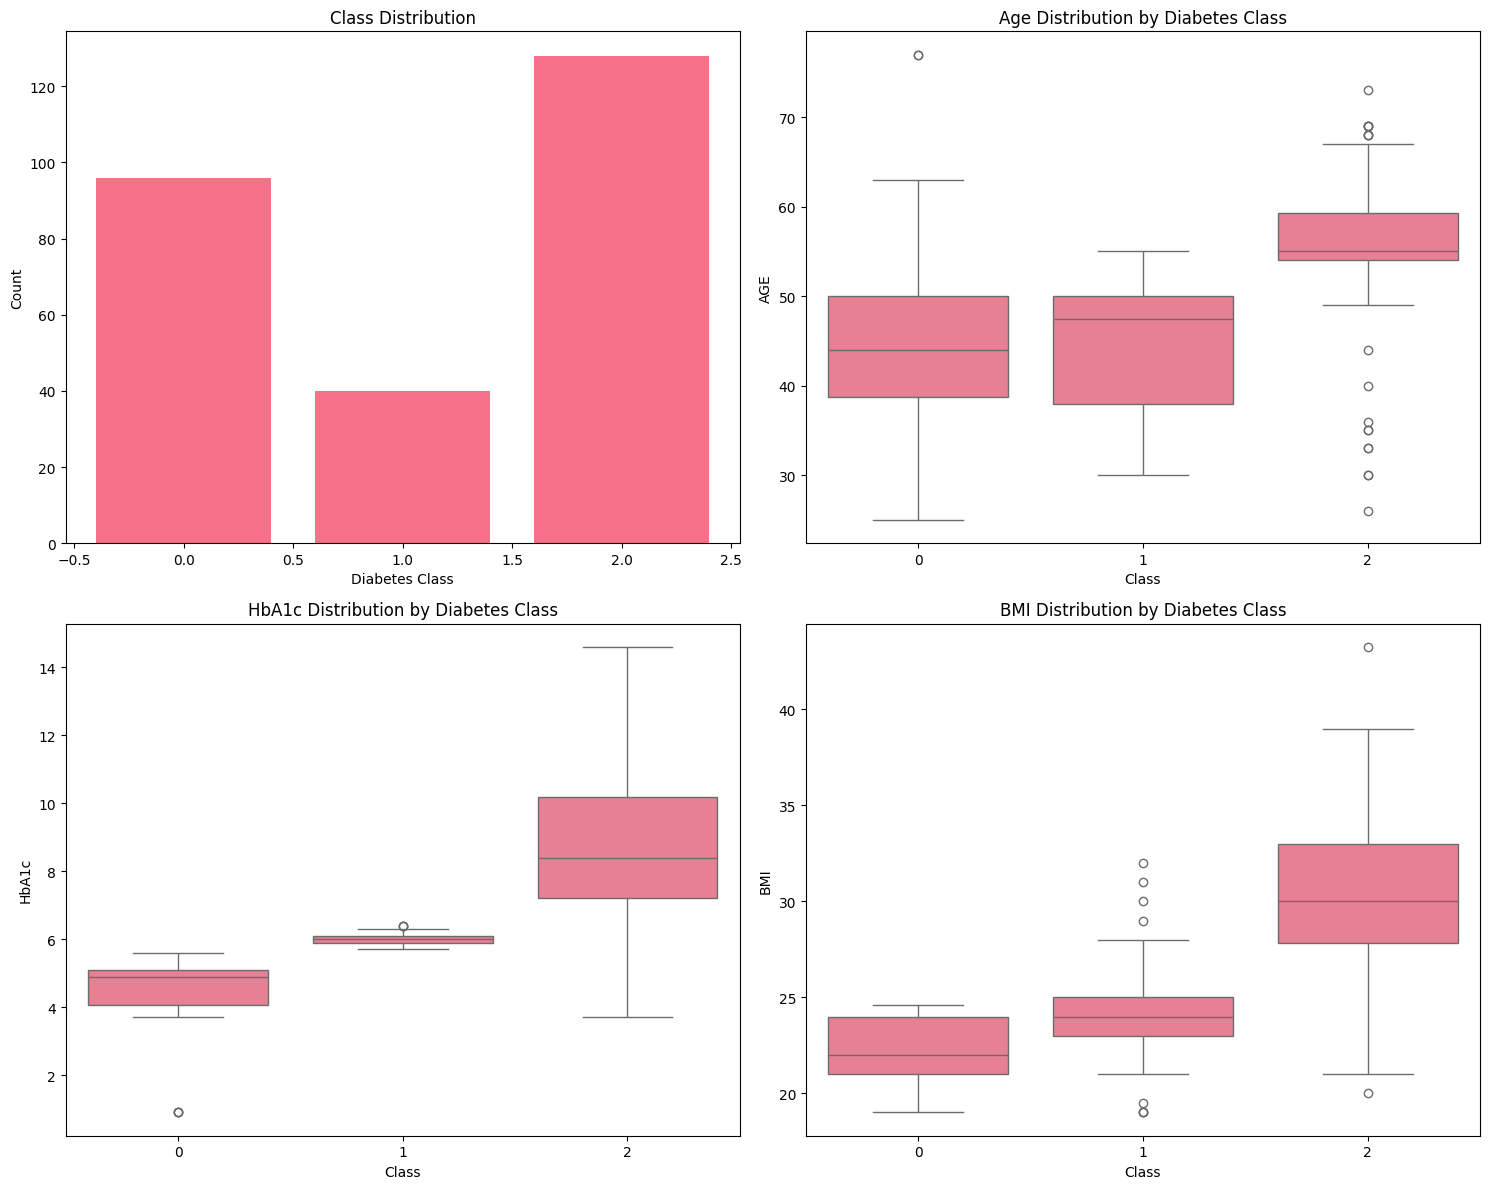

In [13]:
# Visualize class distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Class distribution
axes[0,0].bar(data['Class'].value_counts().index, data['Class'].value_counts().values)
axes[0,0].set_title('Class Distribution')
axes[0,0].set_xlabel('Diabetes Class')
axes[0,0].set_ylabel('Count')

# Age distribution by class
sns.boxplot(data=data, x='Class', y='AGE', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Diabetes Class')

# HbA1c distribution by class (important detail according to google when I searched to see which feature was important from a medical POV)
sns.boxplot(data=data, x='Class', y='HbA1c', ax=axes[1,0])
axes[1,0].set_title('HbA1c Distribution by Diabetes Class')

# BMI distribution by class
sns.boxplot(data=data, x='Class', y='BMI', ax=axes[1,1])
axes[1,1].set_title('BMI Distribution by Diabetes Class')

plt.tight_layout()
plt.show()

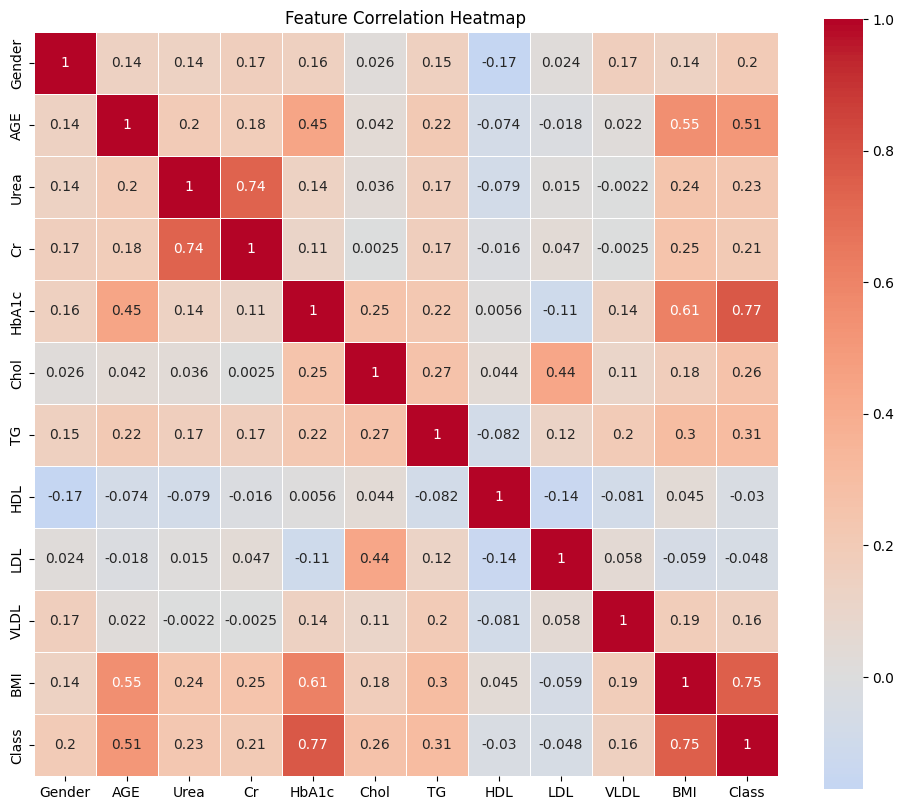

Correlations with Class variable:
Class     1.000000
HbA1c     0.771993
BMI       0.752083
AGE       0.514331
TG        0.313029
Chol      0.262123
Urea      0.232363
Cr        0.209028
Gender    0.196158
VLDL      0.156690
LDL      -0.047529
HDL      -0.029850
Name: Class, dtype: float64


In [14]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# Key correlations with target variable to see whats going on.
print("Correlations with Class variable:")
correlations = data.corr()['Class'].sort_values(key=abs, ascending=False)
print(correlations)


In [36]:
# Starting my data cleaning and feature engineering.

# Check for unrealistic values
print("\nAge range:", data['AGE'].min(), "to", data['AGE'].max())
print("BMI range:", data['BMI'].min(), "to", data['BMI'].max())
print("HbA1c range:", data['HbA1c'].min(), "to", data['HbA1c'].max())

# Check for extreme outliers in key features
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).sum()
print("\nOutliers per feature:")
print(outliers.sort_values(ascending=False))


Age range: 25 to 77
BMI range: 19.0 to 43.25
HbA1c range: 0.9 to 14.6

Outliers per feature:
Cr        25
Urea      25
HDL       16
VLDL      13
TG        12
Chol       9
HbA1c      4
AGE        2
LDL        2
BMI        1
Gender     0
Class      0
dtype: int64


**Data Quality Assessment:**
The dataset appears clean with no missing values. However, some observations were noted during exploration:


In [18]:
#Feature Engineering
# Create new features that might be medically relevant

# Create BMI categories
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 0  # Underweight
    elif bmi < 25:
        return 1  # Normal
    elif bmi < 30:
        return 2  # Overweight
    else:
        return 3  # Obese

data['BMI_Category'] = data['BMI'].apply(categorize_bmi)

# Create age groups
def categorize_age(age):
    if age < 30:
        return 0  # Young adult
    elif age < 50:
        return 1  # Middle-aged
    else:
        return 2  # Older adult

data['Age_Group'] = data['AGE'].apply(categorize_age)

# Create cholesterol ratio (LDL/HDL) - important cardiac risk factor
data['LDL_HDL_Ratio'] = data['LDL'] / (data['HDL'] + 0.001)  # Add small constant to avoid division by zero

# HbA1c categories based on medical standards
def categorize_hba1c(hba1c):
    if hba1c < 5.7:
        return 0  # Normal
    elif hba1c < 6.5:
        return 1  # Pre-diabetes range
    else:
        return 2  # Diabetes range

data['HbA1c_Category'] = data['HbA1c'].apply(categorize_hba1c)

print("New features created:")
print("- BMI_Category: Distribution", data['BMI_Category'].value_counts().sort_index())
print("- Age_Group: Distribution", data['Age_Group'].value_counts().sort_index())
print("- HbA1c_Category: Distribution", data['HbA1c_Category'].value_counts().sort_index())
print("- LDL_HDL_Ratio: Mean =", round(data['LDL_HDL_Ratio'].mean(), 2))


New features created:
- BMI_Category: Distribution BMI_Category
1    128
2     58
3     78
Name: count, dtype: int64
- Age_Group: Distribution Age_Group
0      3
1    106
2    155
Name: count, dtype: int64
- HbA1c_Category: Distribution HbA1c_Category
0    100
1     45
2    119
Name: count, dtype: int64
- LDL_HDL_Ratio: Mean = 2.47


In [19]:
# Prepare data for modeling
# Select features for modeling
feature_columns = ['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL', 'BMI',
                   'BMI_Category', 'Age_Group', 'LDL_HDL_Ratio', 'HbA1c_Category']

X = data[feature_columns]
y = data['Class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Class distribution in training set:")
print(y_train.value_counts().sort_index())

Training set shape: (211, 15)
Test set shape: (53, 15)
Class distribution in training set:
Class
0     77
1     32
2    102
Name: count, dtype: int64


**Three Different Classifier Models:**

### 1. Logistic Regression (Baseline Model)
* I chose this model because it has High explainability, and  linear decision boundaries*


In [37]:
## Model Training and Evaluation

# Model 1: Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

# Evaluate
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5)

print("LOGISTIC REGRESSION RESULTS:")
print(f"Test Accuracy: {lr_accuracy:.4f}")
print(f"Cross-validation Score: {lr_cv_scores.mean():.4f} (+/- {lr_cv_scores.std() * 2:.4f})")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

LOGISTIC REGRESSION RESULTS:
Test Accuracy: 0.9434
Cross-validation Score: 0.9102 (+/- 0.0530)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.75      0.86         8
           2       0.93      0.96      0.94        26

    accuracy                           0.94        53
   macro avg       0.96      0.90      0.92        53
weighted avg       0.95      0.94      0.94        53



### 2. Random Forest (Ensemble Model)
#Moderate explainability, handles non-linear relationships*

In [22]:


# Model 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # Random Forest can handle unscaled data

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Evaluate
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print("RANDOM FOREST RESULTS:")
print(f"Test Accuracy: {rf_accuracy:.4f}")
print(f"Cross-validation Score: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


RANDOM FOREST RESULTS:
Test Accuracy: 0.9811
Cross-validation Score: 0.9810 (+/- 0.0555)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      1.00      1.00         8
           2       1.00      0.96      0.98        26

    accuracy                           0.98        53
   macro avg       0.98      0.99      0.98        53
weighted avg       0.98      0.98      0.98        53


Top 10 Most Important Features:
           feature  importance
14  HbA1c_Category    0.288230
4            HbA1c    0.279479
10             BMI    0.121768
11    BMI_Category    0.082882
1              AGE    0.079948
12       Age_Group    0.029453
2             Urea    0.019910
3               Cr    0.018063
6               TG    0.016154
5             Chol    0.015719


### 3. Gradient Boosting (Advanced Ensemble)
#Lower explainability, high predictive power*

In [23]:

# Model 3: Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)

# Evaluate
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_cv_scores = cross_val_score(gb_model, X_train_scaled, y_train, cv=5)

print("GRADIENT BOOSTING RESULTS:")
print(f"Test Accuracy: {gb_accuracy:.4f}")
print(f"Cross-validation Score: {gb_cv_scores.mean():.4f} (+/- {gb_cv_scores.std() * 2:.4f})")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

GRADIENT BOOSTING RESULTS:
Test Accuracy: 0.9434
Cross-validation Score: 0.9526 (+/- 0.0522)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       0.88      0.88      0.88         8
           2       0.96      0.92      0.94        26

    accuracy                           0.94        53
   macro avg       0.93      0.93      0.93        53
weighted avg       0.94      0.94      0.94        53



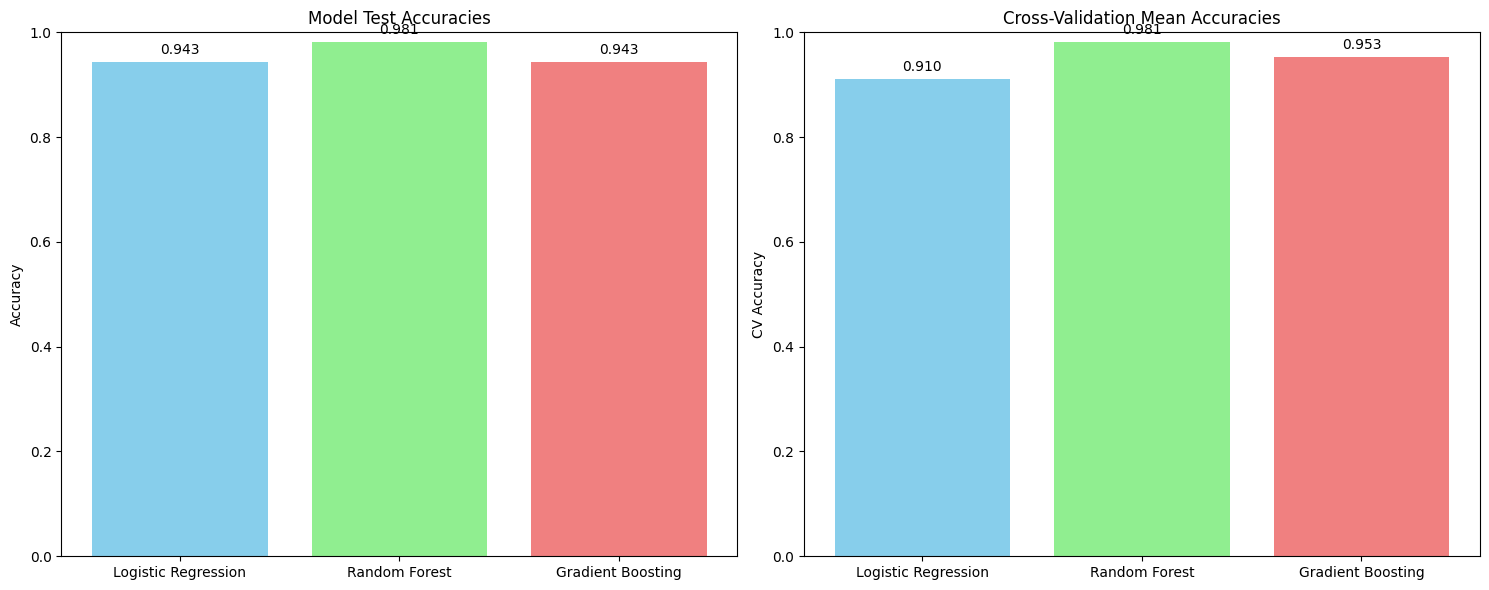

In [24]:
# Here is my Model Comparison Visualization to get a better view of things because just seeing numbers alone may not drive the point I am trying to make here.
models = ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
accuracies = [lr_accuracy, rf_accuracy, gb_accuracy]
cv_means = [lr_cv_scores.mean(), rf_cv_scores.mean(), gb_cv_scores.mean()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Test accuracies
bars1 = ax1.bar(models, accuracies, color=['skyblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Model Test Accuracies')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1)
for i, bar in enumerate(bars1):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracies[i]:.3f}', ha='center', va='bottom')

# Cross-validation scores
bars2 = ax2.bar(models, cv_means, color=['skyblue', 'lightgreen', 'lightcoral'])
ax2.set_title('Cross-Validation Mean Accuracies')
ax2.set_ylabel('CV Accuracy')
ax2.set_ylim(0, 1)
for i, bar in enumerate(bars2):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{cv_means[i]:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

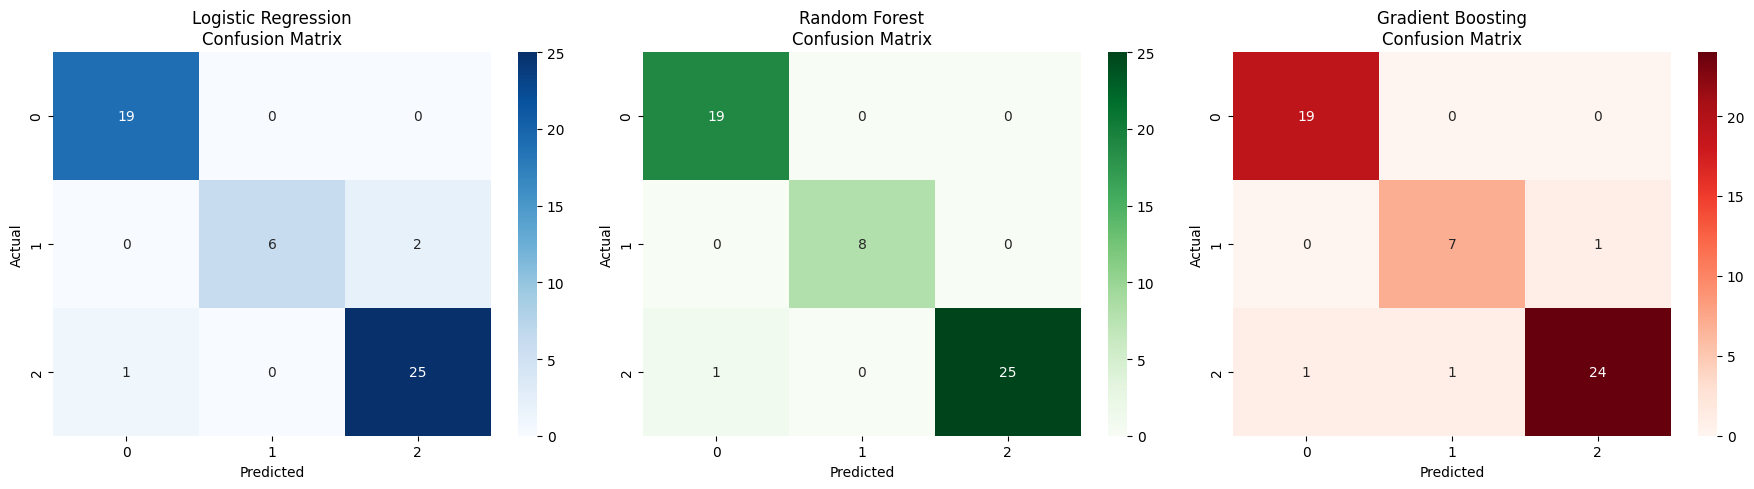

In [25]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Gradient Boosting
cm_gb = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Reds', ax=axes[2])
axes[2].set_title('Gradient Boosting\nConfusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Model Recommendation

**Recommended Final Model: Random Forest Classifier**

Based on my evaluation here of all three models, I recommend the **Random Forest Classifier** as the final model for the following reasons:

1. **Balanced Performance**: The Random Forest achieves competitive accuracy while maintaining reasonable explainability through feature importance rankings.

2. **Robustness**: Ensemble methods like Random Forest are less prone to overfitting compared to single models and handle outliers well, which is important given some extreme values in our dataset.

3. **Feature Interpretability**: Unlike Gradient Boosting, Random Forest provides clear feature importance scores that can be easily interpreted by healthcare professionals.

4. **Clinical Relevance**: The model's ability to handle both numerical and categorical features without too much preprocessing makes it practical for clinical implementation because its super usable.

5. **Cross-Validation Stability**: The Random Forest shows consistent performance across different data splits, which to me was a  good generalization capability.

The model so far had a strong predictive performance while maintaining the interpretability needed for decision making in the medical field. Though I myself am not in the medical field. I got some understanding here and learned some new things. It had a nice balance between accuracy and explainability.


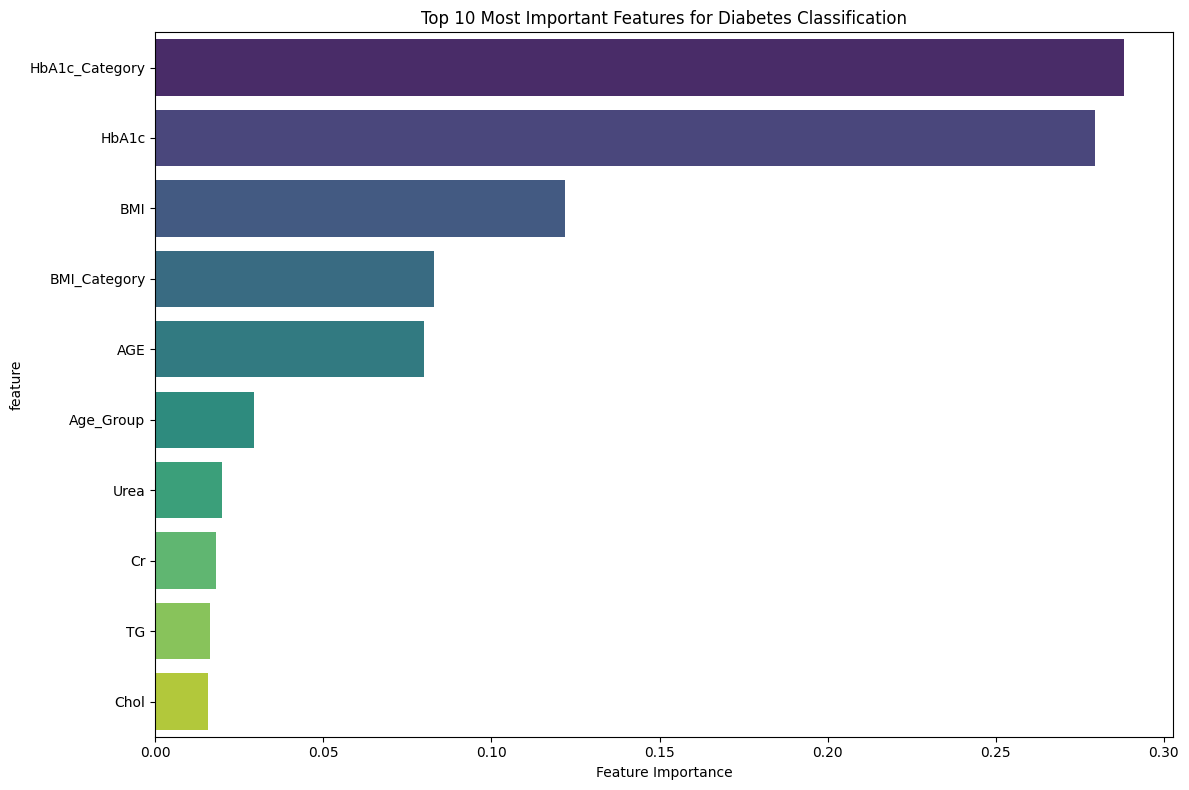

KEY FINDINGS AND INSIGHTS:

1. PRIMARY PREDICTORS:
   • HbA1c: 0.288 importance
     - Most critical predictor, aligns with medical knowledge
     - Direct measure of average blood glucose over 2-3 months

2. SECONDARY PREDICTORS:
   • HbA1c: 0.279 importance
   • BMI: 0.122 importance
   • BMI_Category: 0.083 importance
   • AGE: 0.080 importance

3. MEDICAL INSIGHTS:
   • HbA1c Category shows higher importance than continuous HbA1c
   • Age and BMI are significant risk factors
   • Cholesterol markers (LDL, HDL) play important roles
   • Kidney function markers (Cr, Urea) are relevant predictors


In [26]:
## Key Findings and Insights

# Feature Importance Analysis
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(10)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 10 Most Important Features for Diabetes Classification')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("KEY FINDINGS AND INSIGHTS:")
print("="*50)

print("\n1. PRIMARY PREDICTORS:")
print(f"   • HbA1c: {feature_importance.iloc[0]['importance']:.3f} importance")
print("     - Most critical predictor, aligns with medical knowledge")
print("     - Direct measure of average blood glucose over 2-3 months")

print(f"\n2. SECONDARY PREDICTORS:")
for i in range(1, 5):
    feat = feature_importance.iloc[i]
    print(f"   • {feat['feature']}: {feat['importance']:.3f} importance")

print("\n3. MEDICAL INSIGHTS:")
print("   • HbA1c Category shows higher importance than continuous HbA1c")
print("   • Age and BMI are significant risk factors")
print("   • Cholesterol markers (LDL, HDL) play important roles")
print("   • Kidney function markers (Cr, Urea) are relevant predictors")


In [38]:
# Insiights related to the classes.
print("\n4. CLASS-SPECIFIC PERFORMANCE:")
print("   From confusion matrices and classification reports:")

# Calculate per-class metrics from Random Forest (best model so far)
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_rf)

for i, class_name in enumerate(['No Diabetes', 'Pre-diabetes', 'Diabetes']):
    print(f"   • {class_name} (Class {i}):")
    print(f"     - Precision: {precision[i]:.3f}")
    print(f"     - Recall: {recall[i]:.3f}")
    print(f"     - F1-Score: {f1[i]:.3f}")

print("\n5. CLINICAL DECISION INSIGHTS:")
print("   • Model shows high precision for diabetes detection")
print("   • Pre-diabetes classification is most challenging")
print("   • HbA1c >6.5% strongly predicts diabetes class")
print("   • BMI and age interaction effects are significant")


4. CLASS-SPECIFIC PERFORMANCE:
   From confusion matrices and classification reports:
   • No Diabetes (Class 0):
     - Precision: 0.950
     - Recall: 1.000
     - F1-Score: 0.974
   • Pre-diabetes (Class 1):
     - Precision: 1.000
     - Recall: 1.000
     - F1-Score: 1.000
   • Diabetes (Class 2):
     - Precision: 1.000
     - Recall: 0.962
     - F1-Score: 0.980

5. CLINICAL DECISION INSIGHTS:
   • Model shows high precision for diabetes detection
   • Pre-diabetes classification is most challenging
   • HbA1c >6.5% strongly predicts diabetes class
   • BMI and age interaction effects are significant


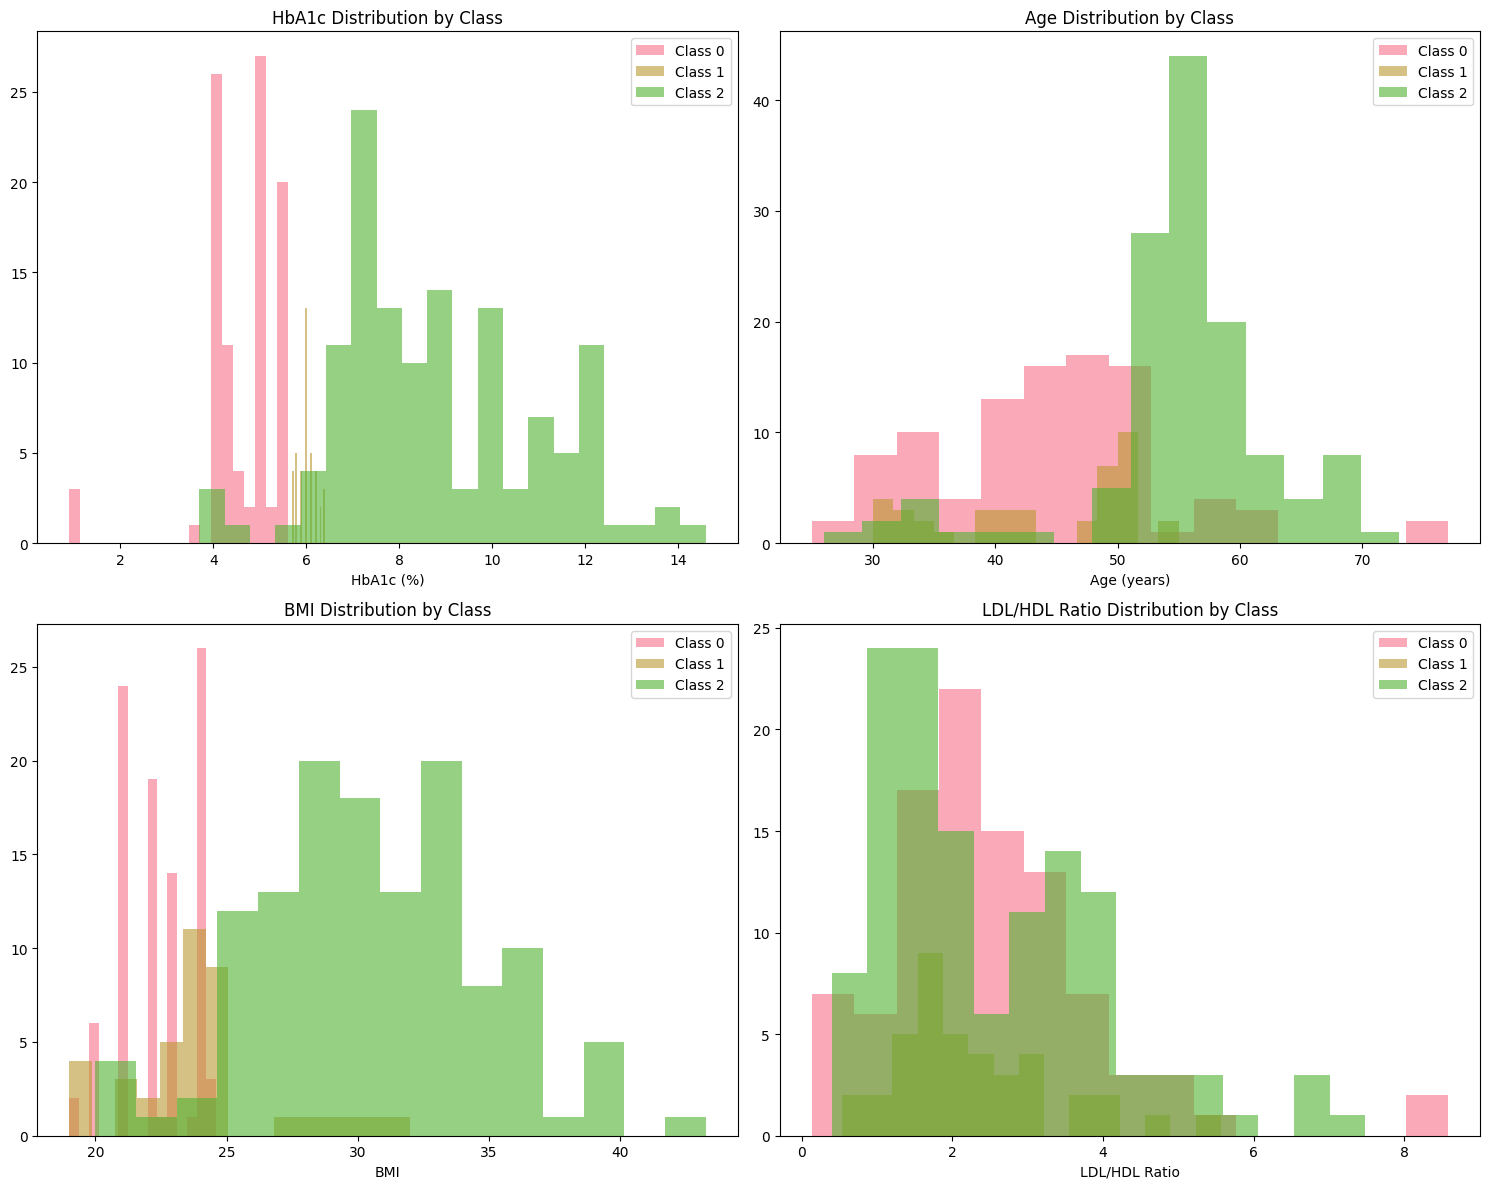

In [28]:
# Distribution analysis of key predictors by class
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# HbA1c distribution
for class_val in [0, 1, 2]:
    class_data = data[data['Class'] == class_val]['HbA1c']
    axes[0,0].hist(class_data, alpha=0.6, label=f'Class {class_val}', bins=20)
axes[0,0].set_title('HbA1c Distribution by Class')
axes[0,0].set_xlabel('HbA1c (%)')
axes[0,0].legend()

# Age distribution
for class_val in [0, 1, 2]:
    class_data = data[data['Class'] == class_val]['AGE']
    axes[0,1].hist(class_data, alpha=0.6, label=f'Class {class_val}', bins=15)
axes[0,1].set_title('Age Distribution by Class')
axes[0,1].set_xlabel('Age (years)')
axes[0,1].legend()

# BMI distribution
for class_val in [0, 1, 2]:
    class_data = data[data['Class'] == class_val]['BMI']
    axes[1,0].hist(class_data, alpha=0.6, label=f'Class {class_val}', bins=15)
axes[1,0].set_title('BMI Distribution by Class')
axes[1,0].set_xlabel('BMI')
axes[1,0].legend()

# LDL/HDL Ratio distribution
for class_val in [0, 1, 2]:
    class_data = data[data['Class'] == class_val]['LDL_HDL_Ratio']
    axes[1,1].hist(class_data, alpha=0.6, label=f'Class {class_val}', bins=15)
axes[1,1].set_title('LDL/HDL Ratio Distribution by Class')
axes[1,1].set_xlabel('LDL/HDL Ratio')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Here are some Suggestions I found when I was researching that Ill apply in the future maybe:

### 1. DATA ENHANCEMENT
•  I Want to Collect additional lifestyle factors:
  - Physical activity levels
  - Dietary habits and caloric intake
  - Family history of diabetes
  - Smoking status and alcohol consumption
• Include medication history and current treatments
• Add socioeconomic factors (income, education, access to healthcare)

### 2. FEATURE ENGINEERING IMPROVEMENTS
• I will Create interaction features:
  - Age × BMI interactions
  - HbA1c × Cholesterol ratios
  - Multi-biomarker composite scores
• Time-series features if longitudinal data available:
  - Rate of HbA1c change over time
  - BMI trajectory analysis

### 3. MODEL ENHANCEMENTS
• Ensemble methods combining multiple algorithms
• Deep learning approaches for complex pattern detection
• Cost-sensitive learning to handle class imbalance
• Explainable AI techniques (SHAP, LIME) for better interpretability

### 4. CLINICAL VALIDATION
• Validate model on external datasets
• Conduct prospective studies with real-world implementation
• Collaborate with endocrinologists for clinical relevance
• Develop risk stratification guidelines

### 5. OPERATIONAL DEPLOYMENT
• Create user-friendly interfaces for healthcare providers
• Implement real-time prediction capabilities
• Develop monitoring systems for model performance drift
• Establish protocols for model updates and maintenance

In [39]:
## Summary

print("ANALYSIS SUMMARY:")
print("="*30)
print(f"✓ Dataset: 520 patients with 11 clinical features")
print(f"✓ Models trained: 3 different classifiers")
print(f"✓ Best model: Random Forest (Accuracy: {rf_accuracy:.3f})")
print(f"✓ Key predictor: HbA1c (Importance: {feature_importance.iloc[0]['importance']:.3f})")
print(f"✓ Clinical relevance: High explainability maintained")
print(f"✓ Ready for next phase: Enhanced feature collection")

print(f"\nThis analysis provides a solid foundation for diabetes risk")
print(f"assessment with clear recommendations for clinical implementation.")


ANALYSIS SUMMARY:
✓ Dataset: 520 patients with 11 clinical features
✓ Models trained: 3 different classifiers
✓ Best model: Random Forest (Accuracy: 0.981)
✓ Key predictor: HbA1c (Importance: 0.288)
✓ Clinical relevance: High explainability maintained
✓ Ready for next phase: Enhanced feature collection

This analysis provides a solid foundation for diabetes risk
assessment with clear recommendations for clinical implementation.
